In [11]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

from matplotlib import pyplot as plt
%matplotlib inline

## Bernoulli Bandit

We are going to implement several exploration strategies for simplest problem - bernoulli bandit.

The bandit has $K$ actions. Action produce 1.0 reward $r$ with probability $0 \le \theta_k \le 1$ which is unknown to agent, but fixed over time. Agent's objective is to minimize regret over fixed number $T$ of action selections:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

Where $\theta^* = \max_k\{\theta_k\}$

**Real-world analogy:**

Clinical trials - we have $K$ pills and $T$ ill patient. After taking pill, patient is cured with probability $\theta_k$. Task is to find most efficient pill.

A research on clinical trials - https://arxiv.org/pdf/1507.08025.pdf

In [12]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)
        
    @property
    def action_count(self):
        return len(self._probs)
    
    def pull(self, action):
        if np.random.random() > self._probs[action]:
            return 0.0
        return 1.0
    
    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)
    
    def step(self):
        """ Used in nonstationary version
        """
        pass
    
    def reset(self):
        """ Used in nonstationary version
        """

In [13]:
class AbstractAgent(metaclass=ABCMeta):   
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0
    
    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass
    
    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1
    
    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):    
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Epsilon-greedy agent

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Implement the algorithm above in the cell below:

In [14]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon = 0.01):
        self._epsilon = epsilon

    def get_action(self):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, len(self._successes))
        
        n_actions = self._successes + self._failures
        p = self._successes / n_actions
        return np.argmax(p)
        
    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon) 

### UCB Agent
Epsilon-greedy strategy heve no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents otimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

>> **end for** 

>> $x_t \leftarrow argmax_{k}w$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**


__Note:__ in practice, one can multiply $\sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$ by some tunable parameter to regulate agent's optimism and wilingness to abandon non-promising actions.

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [19]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        n_actions = self._successes + self._failures
        v = np.sqrt(2 * np.log(self._total_pulls) / n_actions)
        
        p = self._successes/(n_actions) + v
        return np.argmax(p)
    
    @property
    def name(self):
        return self.__class__.__name__

### Thompson sampling

UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**
 

More on Tompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [20]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        p = np.random.beta(self._successes+1, self._failures+1)
        return np.argmax(p)
    
    @property
    def name(self):
        return self.__class__.__name__

In [21]:
from collections import OrderedDict
def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
        agent.name : [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trials):
        env.reset()
        
        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()
            
            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward
                
            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials
    
    return scores

def plot_regret(scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in scores])
    
    plt.ylabel("regret")
    plt.xlabel("steps")
    
    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


AttributeError: 'str' object has no attribute 'name'

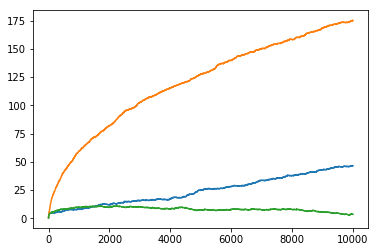

In [22]:
# Uncomment agents
agents = [
     EpsilonGreedyAgent(),
     UCBAgent(),
     ThompsonSamplingAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(regret)

### Submit to coursera

In [ ]:
from submit import submit_bandits

submit_bandits(regret, <EMAIL>, <TOKEN>)